In [1]:
library(ggplot2)
library(Seurat)
library(plyr)
library(dplyr)
library(Matrix)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
aggr.data <- Read10X("AngII_treat_CR6_no_norm/filtered_feature_bc_matrix")

genes.seurat <- CreateSeuratObject(aggr.data, min.cells = 10, min.features = 200, project = "AngII")
dim(genes.seurat)
remove(aggr.data)

genes.seurat[["percent.mt"]] <- PercentageFeatureSet(genes.seurat, pattern = "^mt-")

experiment <- sub(".*-(.*)","\\1", colnames(genes.seurat))
experiment <- plyr::mapvalues(experiment, from = as.character(seq(1, 8)),
                             to = c("No_treat_rep1", "AngII_treat_rep1", "Saline_treat_rep1", "AngII_treat_rep2",
                                   "No_treat_rep2", "AngII_treat_rep3", "Saline_treat_rep2", "AngII_treat_rep4"))

names(experiment) = colnames(genes.seurat)
table(experiment)
genes.seurat <- AddMetaData(genes.seurat, experiment, col.name = "Experiment")

condition <- sub("(.*)_.*_.*", "\\1", experiment)
condition <- plyr::mapvalues(condition, 
                             from = c("No", "Saline"), 
                             to = c("Healthy", "Healthy"))

genes.seurat <- AddMetaData(genes.seurat, condition, col.name = "Condition")

[1] 18267 38075

experiment
 AngII_treat_rep1  AngII_treat_rep2  AngII_treat_rep3  AngII_treat_rep4 
             3501              5782              4247              5193 
    No_treat_rep1     No_treat_rep2 Saline_treat_rep1 Saline_treat_rep2 
             4862              4632              5929              3929 

Plot some QC metrics:

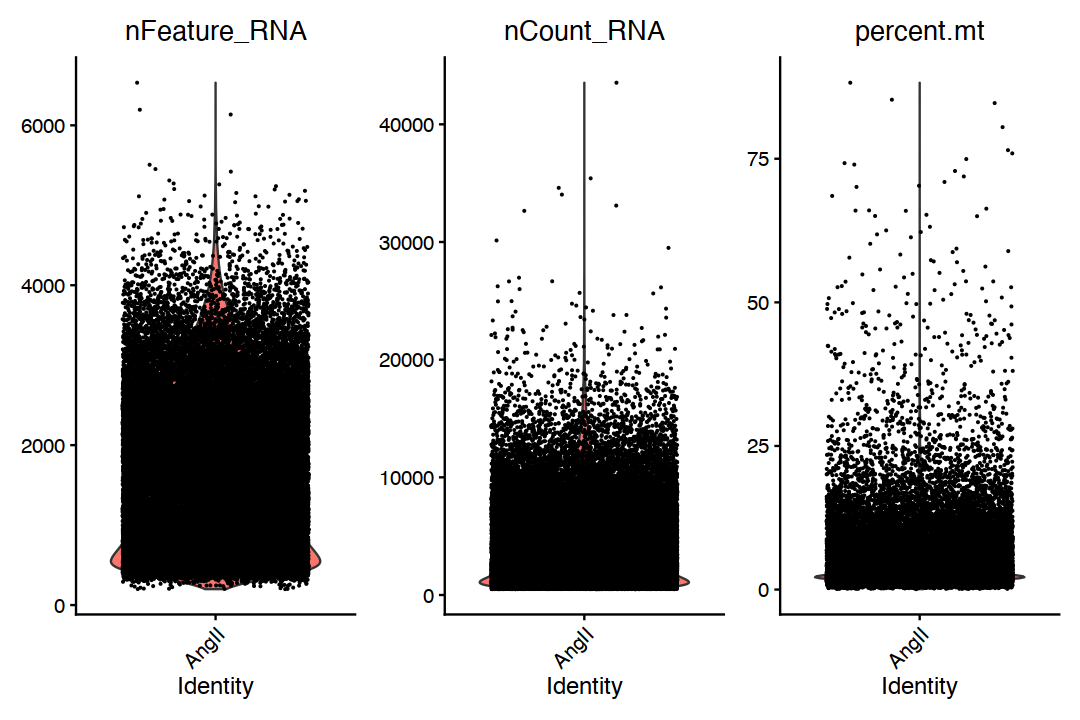

In [3]:
#Violin plot of QC metrics
options(repr.plot.width=9, repr.plot.height=6)
VlnPlot(genes.seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


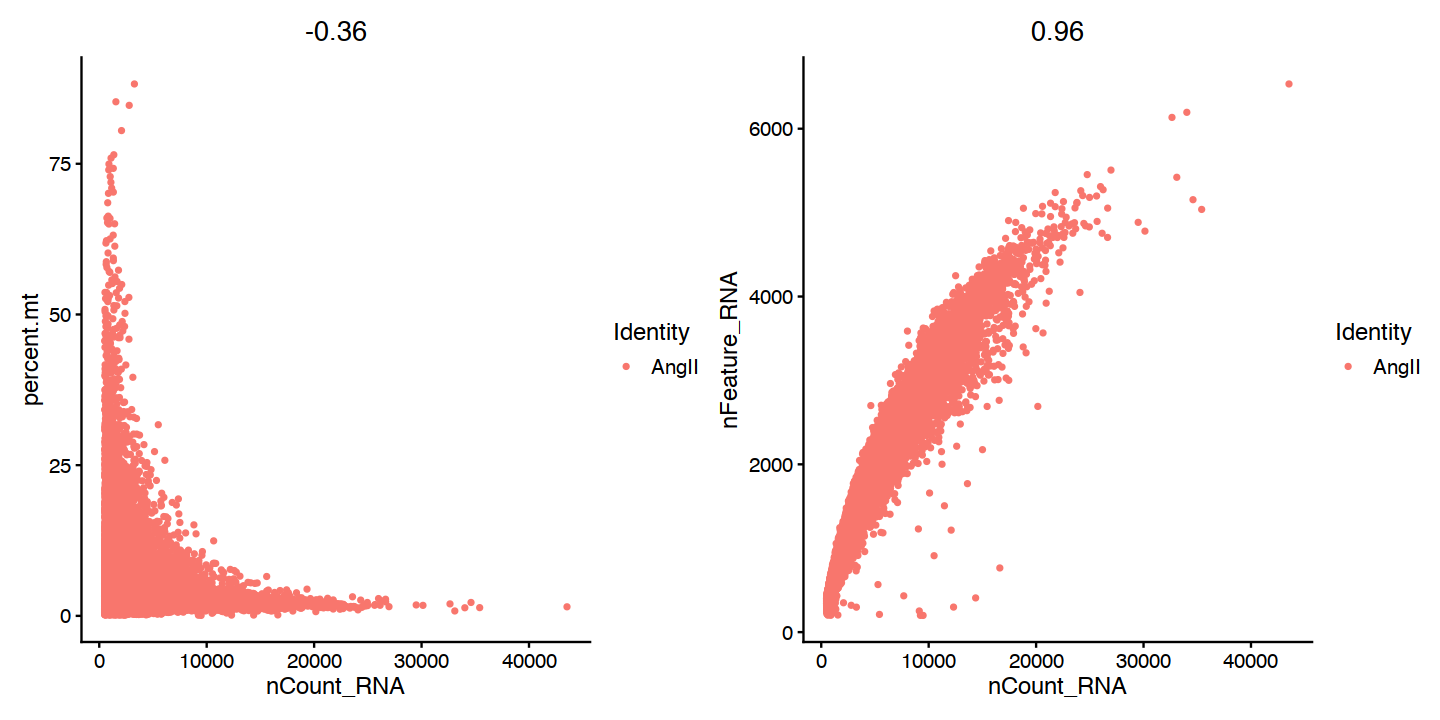

In [5]:
options(repr.plot.width=12, repr.plot.height=6)
plot1 <- FeatureScatter(genes.seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(genes.seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [6]:
genes.seurat <- subset(genes.seurat, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 10 &
                         nCount_RNA > 500 & nCount_RNA < 18000)
dim(genes.seurat)

# Normalise data
genes.seurat <- NormalizeData(object = genes.seurat, 
                              normalization.method = "LogNormalize", 
                              scale.factor = 10000)

# Find higly variable genes
genes.seurat <- FindVariableFeatures(object = genes.seurat, mean.function = "vst", nfeatures = 3000)

# Regress of unwanted variation
genes.seurat <- ScaleData(genes.seurat, 
                          vars.to.regress = c("nCount_RNA", "nFeature_RNA"), 
                          verbose = TRUE)

genes.seurat <- RunPCA(object = genes.seurat, features = VariableFeatures(object = genes.seurat))

## Clustering
genes.seurat <- FindNeighbors(genes.seurat, dims = 1:25)
genes.seurat <- FindClusters(genes.seurat, resolution = seq(0.4, 1.2, 0.2))

### UMAP/t-SNE analysis
genes.seurat <- RunUMAP(genes.seurat, dims = 1:25)

Idents(genes.seurat) <- genes.seurat@meta.data$RNA_snn_res.0.6

[1] 18267 33368

Regressing out nCount_RNA, nFeature_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  Dcn, Igfbp7, Gsn, Col1a1, Col1a2, Bgn, Sparc, Serpinh1, Ccdc80, Fstl1 
	   Col3a1, Serping1, Pcolce, Lum, Htra3, Col6a1, Dpt, Fbln1, Loxl1, Mmp2 
	   Col6a2, Cygb, Meg3, Mfap5, Islr, Serpinf1, Mgp, Gas1, Gpm6b, Entpd2 
Negative:  Ctss, Ctsc, Csf1r, Fcgr3, C1qc, Fcer1g, C1qa, C1qb, Laptm5, Tyrobp 
	   Lyz2, Ms4a6c, Adgre1, C5ar1, Ly86, Alox5ap, Lcp1, Fcgr2b, Cd53, Cd14 
	   Ucp2, Ms4a6b, Pld4, Cd68, Pf4, Spi1, Cybb, Mrc1, Fcrls, Unc93b1 
PC_ 2 
Positive:  Cav1, Fabp4, Esam, Cavin2, Egfl7, Cav2, Cdh5, Pecam1, Icam2, Cd36 
	   Gpihbp1, Tinagl1, Emcn, Slc9a3r2, Ly6c1, Tspan13, Flt1, Mgll, Ecscr, Id1 
	   Adgrl4, Cd200, Tcf15, Tie1, Aqp1, Gng11, Cd300lg, Kank3, Mmrn2, Bcam 
Negative:  Gsn, Htra3, Col1a1, Col3a1, Smoc2, Clec3b, Serping1, Dcn, Lgals1, Col1a2 
	   Col6a1, Fbln1, Gpx3, Igfbp4, Pcolce, Dpt, Serpinf1, Loxl1, Col6a2, Mmp2 
	   Entpd2, Dpep1, Pmp22, Ogn, Crispld2, Ifi27l2a, Pdgfra, Gas1, G

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 33368
Number of edges: 1104100

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9266
Number of communities: 20
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 33368
Number of edges: 1104100

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9085
Number of communities: 21
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 33368
Number of edges: 1104100

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8949
Number of communities: 24
Elapsed time: 5 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 33368
Number of edges: 1104100

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8840
Number of communities: 28
Elapsed time: 5 seconds
Modulari

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:28:48 UMAP embedding parameters a = 0.9922 b = 1.112

12:28:48 Read 33368 rows and found 25 numeric columns

12:28:48 Using Annoy for neighbor search, n_neighbors = 30

12:28:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:28:50 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//RtmpL23WDq/file140a126bdc0f4

12:28:50 Searching Annoy index using 1 thread, search_k = 3000

12:28:57 Annoy recall = 100%

12:28:57 Commencing smooth kNN distance calibr

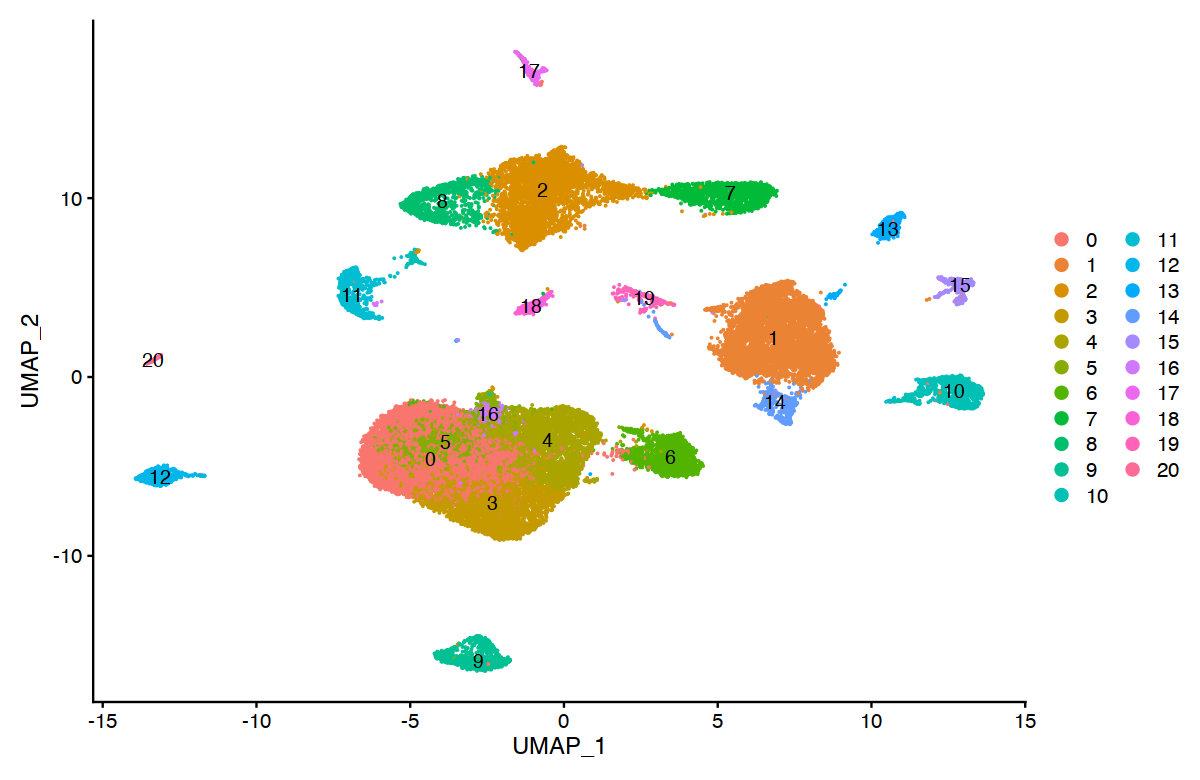

In [7]:
options(repr.plot.width=10, repr.plot.height=6.5) 
DimPlot(genes.seurat, reduction = "umap", label = TRUE)

# Doublet filtering
Visualise and filter doublets identified with Scrublet

[1] "Predicted singlets from Scrublet: 37661"
[1] "Overlap with filtered data: 32908"


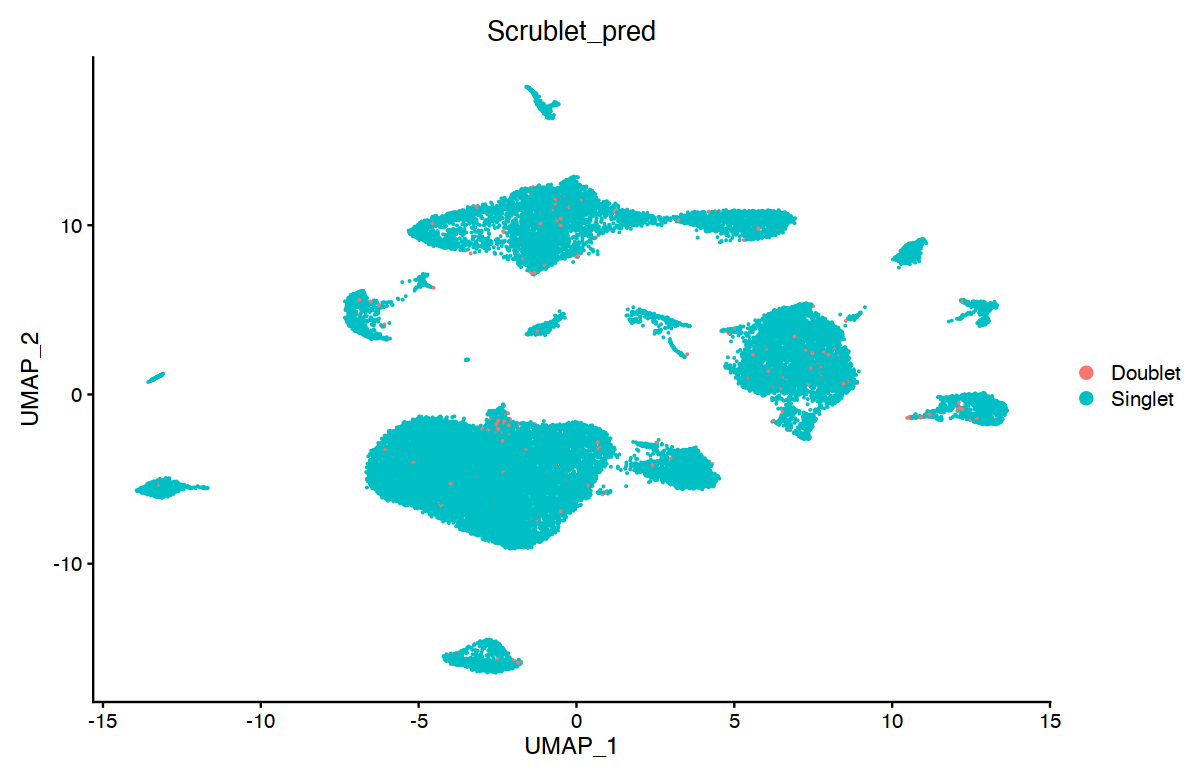

In [8]:
# Visualise the doublets of the UMAP plot
singlet.files <- c("Scrublet/AP18002_no_treatment_rep1_singlets.txt",
                   "Scrublet/AP18003_AngII_treatment_rep1_singlets.txt",
                   "Scrublet/AP18004_saline_treatment_rep1_singlets.txt",
                   "Scrublet/AP18005_AngII_treatment_rep2_singlets.txt",
                   "Scrublet/AP18006_no_treatment_rep2_singlets.txt",
                   "Scrublet/AP18007_AngII_treatment_rep3_singlets.txt",
                   "Scrublet/AP18008_saline_treatment_rep2_singlets.txt",
                   "Scrublet/AP18009_AngII_treatment_rep4_singlets.txt")

all.singlets <- c()
for (this.file in singlet.files) {
  singlets <- readLines(this.file)
  all.singlets <- append(all.singlets, singlets)
}
print(paste("Predicted singlets from Scrublet:", length(all.singlets)))
print(paste("Overlap with filtered data:", length(intersect(colnames(genes.seurat), all.singlets))))

scrublet.doublet <- ifelse(colnames(genes.seurat) %in% all.singlets, "Singlet", "Doublet")
genes.seurat@meta.data$Scrublet_pred <- scrublet.doublet

options(repr.plot.width=10, repr.plot.height=6.5)
DimPlot(genes.seurat, group.by = "Scrublet_pred")

In [9]:
# Filter the Seurat object for the singlets
genes.seurat <- subset(genes.seurat, Scrublet_pred == "Singlet")
dim(genes.seurat)

# Normalise data
genes.seurat <- NormalizeData(object = genes.seurat, 
                              normalization.method = "LogNormalize", 
                              scale.factor = 10000)

# Find higly variable genes
genes.seurat <- FindVariableFeatures(object = genes.seurat, mean.function = "vst", nfeatures = 3000)

# Regress of unwanted variation
genes.seurat <- ScaleData(genes.seurat, 
                          vars.to.regress = c("nCount_RNA"), 
                          model.use = "negbinom", 
                          verbose = TRUE)

genes.seurat <- RunPCA(object = genes.seurat, features = VariableFeatures(object = genes.seurat), npcs=50)

## Clustering
genes.seurat <- FindNeighbors(genes.seurat, k.param = 25, dims = 1:25)
genes.seurat <- FindClusters(genes.seurat, resolution = c(0.7, 0.8, 0.9, 1))

### UMAP/t-SNE analysis
genes.seurat <- RunUMAP(genes.seurat, 
                        n.neighbors = 30, 
                        dims = 1:30,
                        min.dist = 0.3,
                        seed.use = 25)



[1] 18267 32908

Regressing out nCount_RNA

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“step size truncated due to divergence”
glm.nb failed for gene Stfa1; falling back to scale(log(y+1))

Warning message:
“step size truncated due to divergence”
glm.nb failed for gene Gypa; falling back to scale(log(y+1))

Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message in glm.nb(formula = fmla, data = regression.mat):
“alternation limit reached”
Warning message in glm.nb(fo

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32908
Number of edges: 1196734

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9094
Number of communities: 22
Elapsed time: 5 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32908
Number of edges: 1196734

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9032
Number of communities: 27
Elapsed time: 5 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32908
Number of edges: 1196734

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8990
Number of communities: 29
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32908
Number of edges: 1196734

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8945
Number of communities: 31
Elapsed time: 5 seconds


14:57:36 UMAP embedding parameters a = 0.9922 b = 1.112

14:57:37 Read 32908 rows and found 30 numeric columns

14:57:37 Using Annoy for neighbor search, n_neighbors = 30

14:57:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:57:39 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//RtmpL23WDq/file140a129914209

14:57:39 Searching Annoy index using 1 thread, search_k = 3000

14:57:45 Annoy recall = 100%

14:57:46 Commencing smooth kNN distance calibration using 1 thread

14:57:47 Initializing from normalized Laplacian + noise

14:57:50 Commencing optimization for 200 epochs, with 1384938 positive edges

14:58:06 Optimization finished



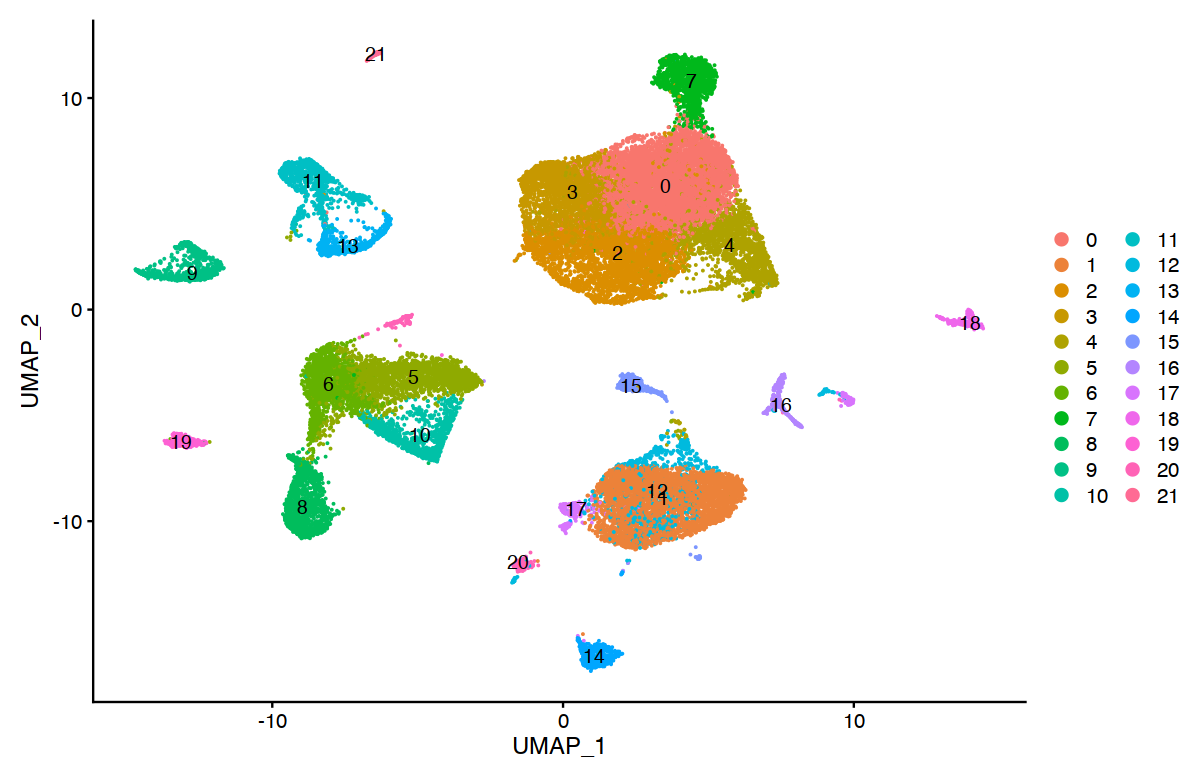

In [10]:
Idents(genes.seurat) <- genes.seurat@meta.data$RNA_snn_res.0.7

DimPlot(genes.seurat, reduction = "umap", label = TRUE)

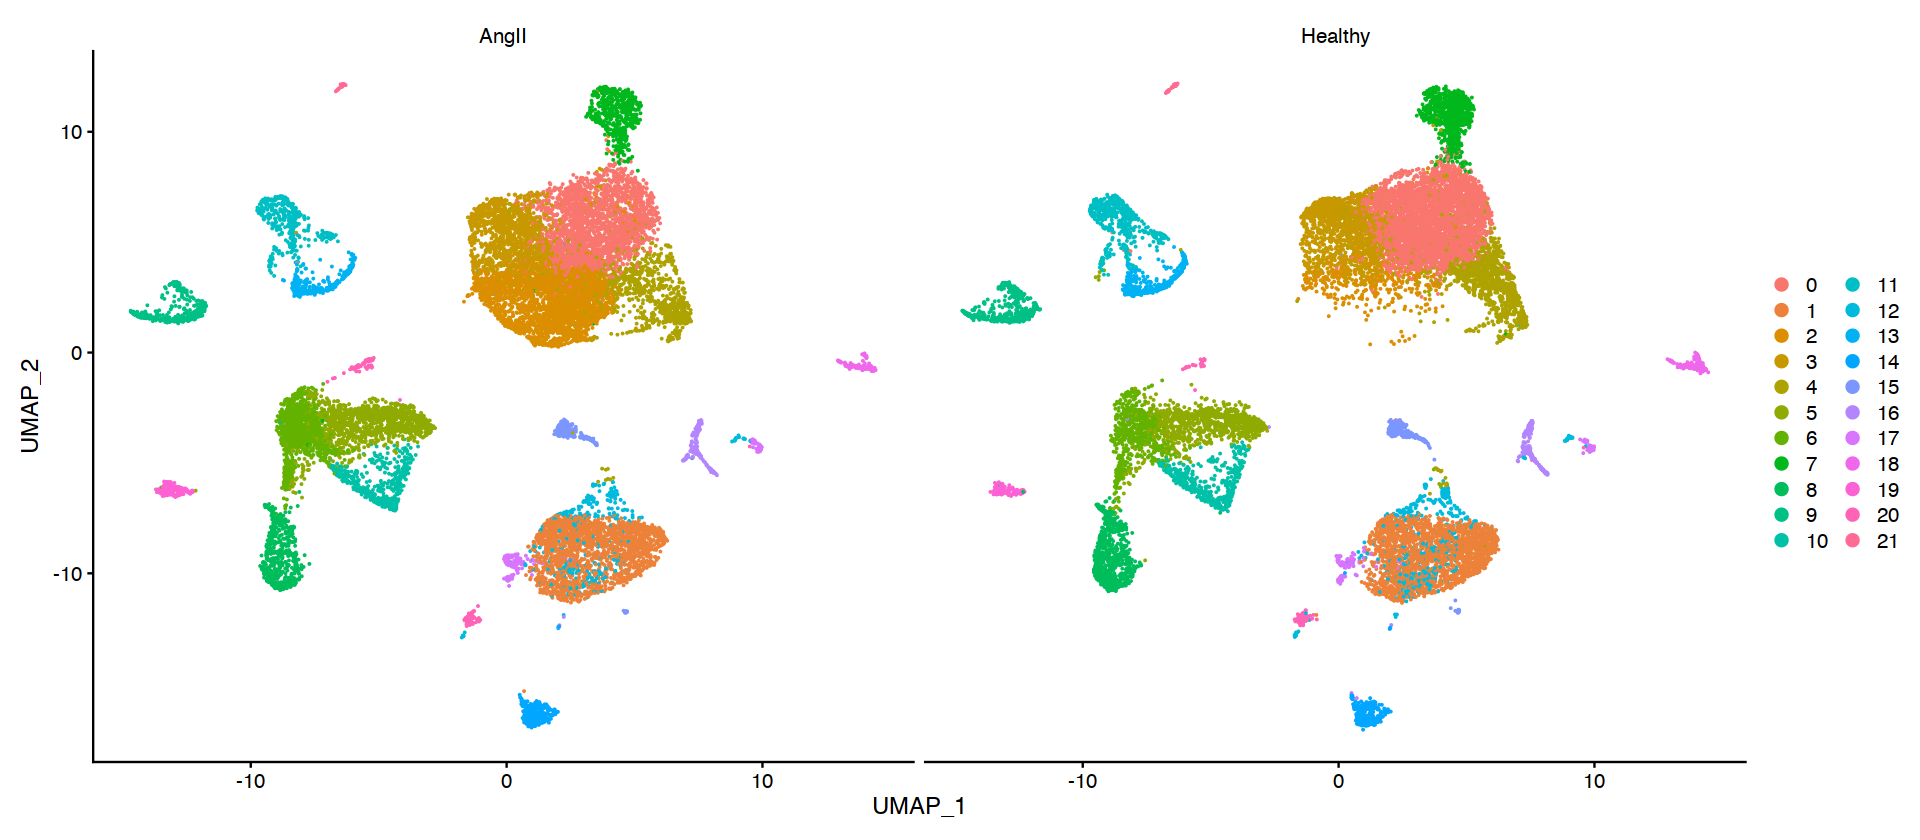

In [12]:
options(repr.plot.width=16, repr.plot.height=7)
DimPlot(genes.seurat, reduction = "umap", split.by = "Condition", ncol=4)

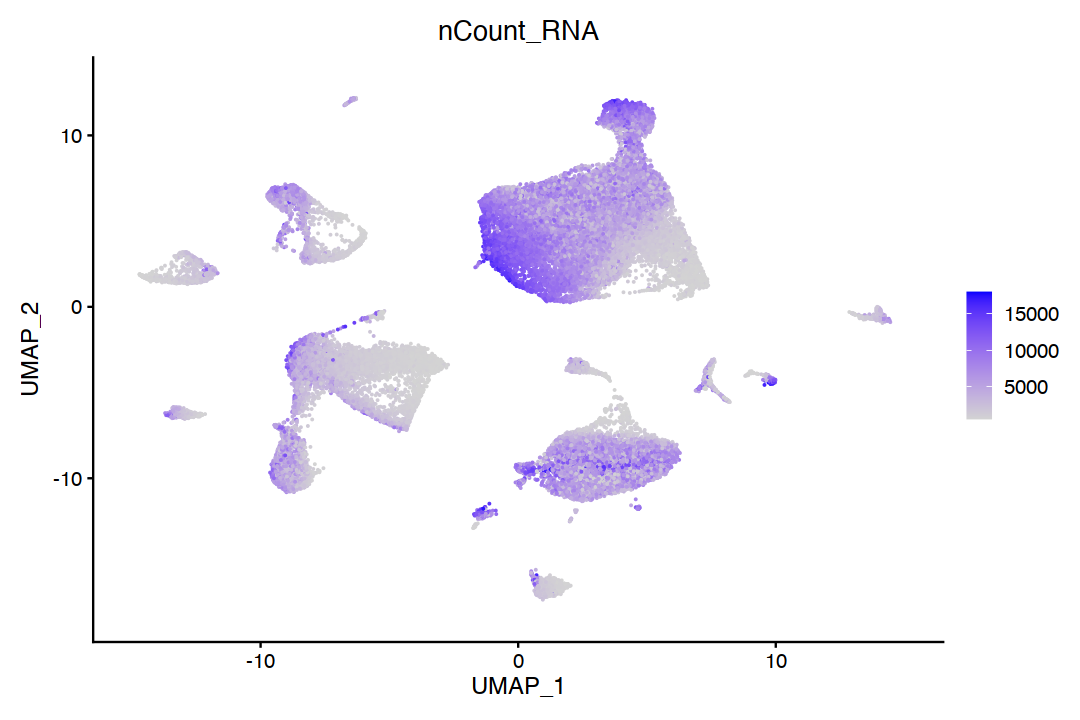

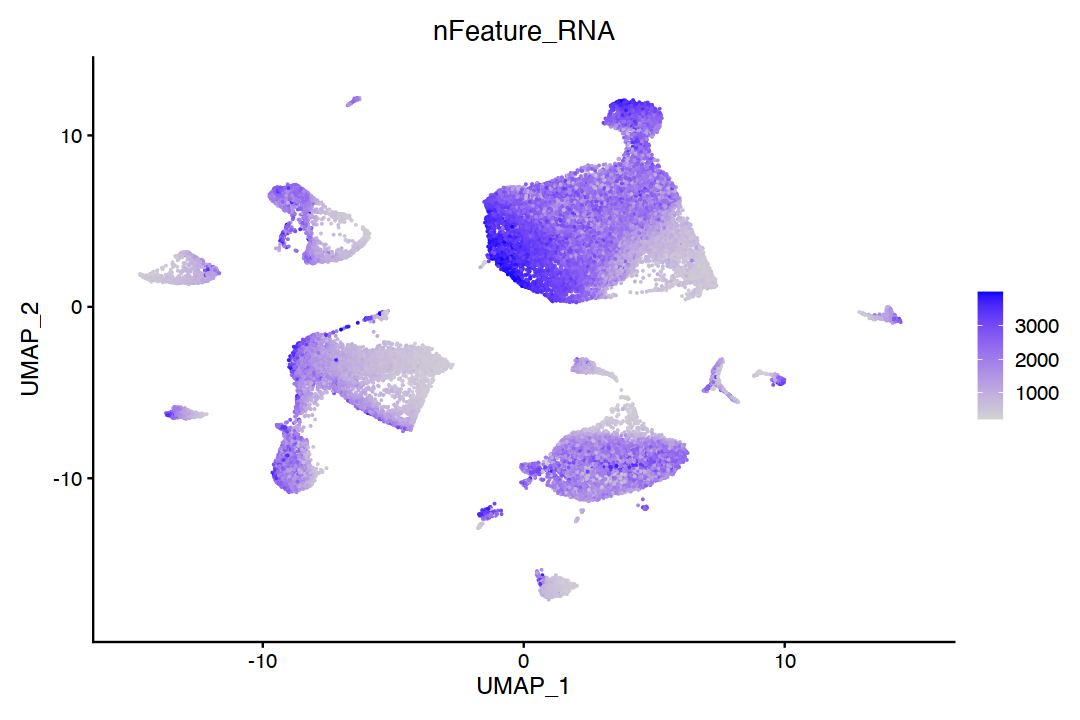

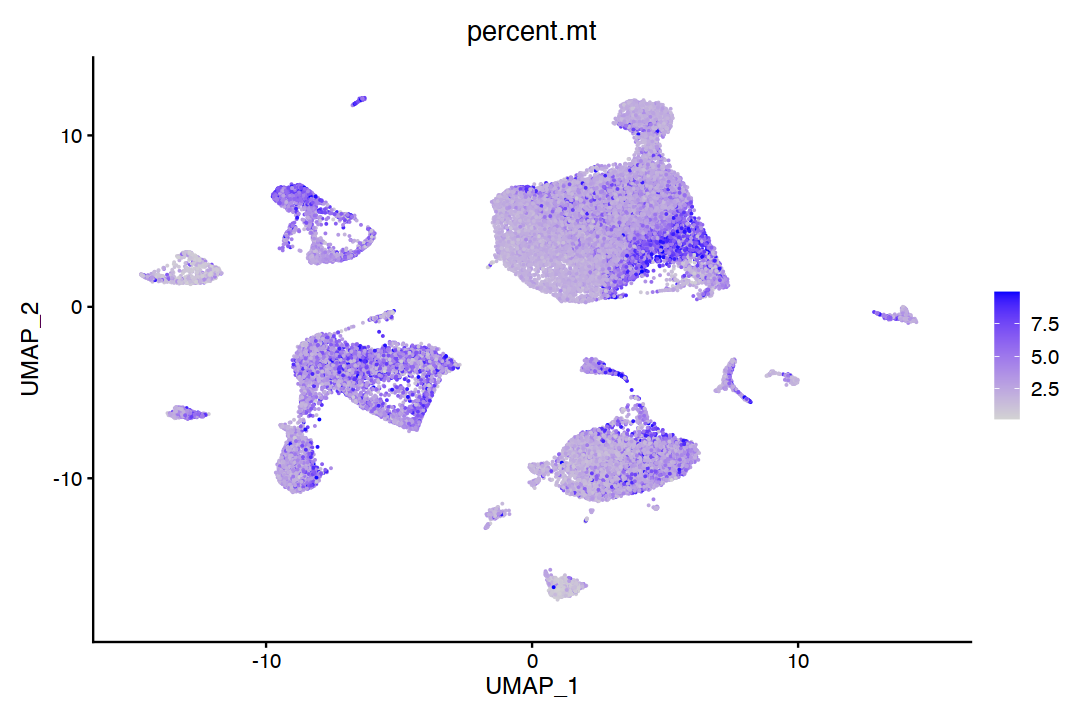

In [13]:
options(repr.plot.width=9, repr.plot.height=6)
FeaturePlot(genes.seurat, "nCount_RNA")
FeaturePlot(genes.seurat, "nFeature_RNA")
FeaturePlot(genes.seurat, "percent.mt")

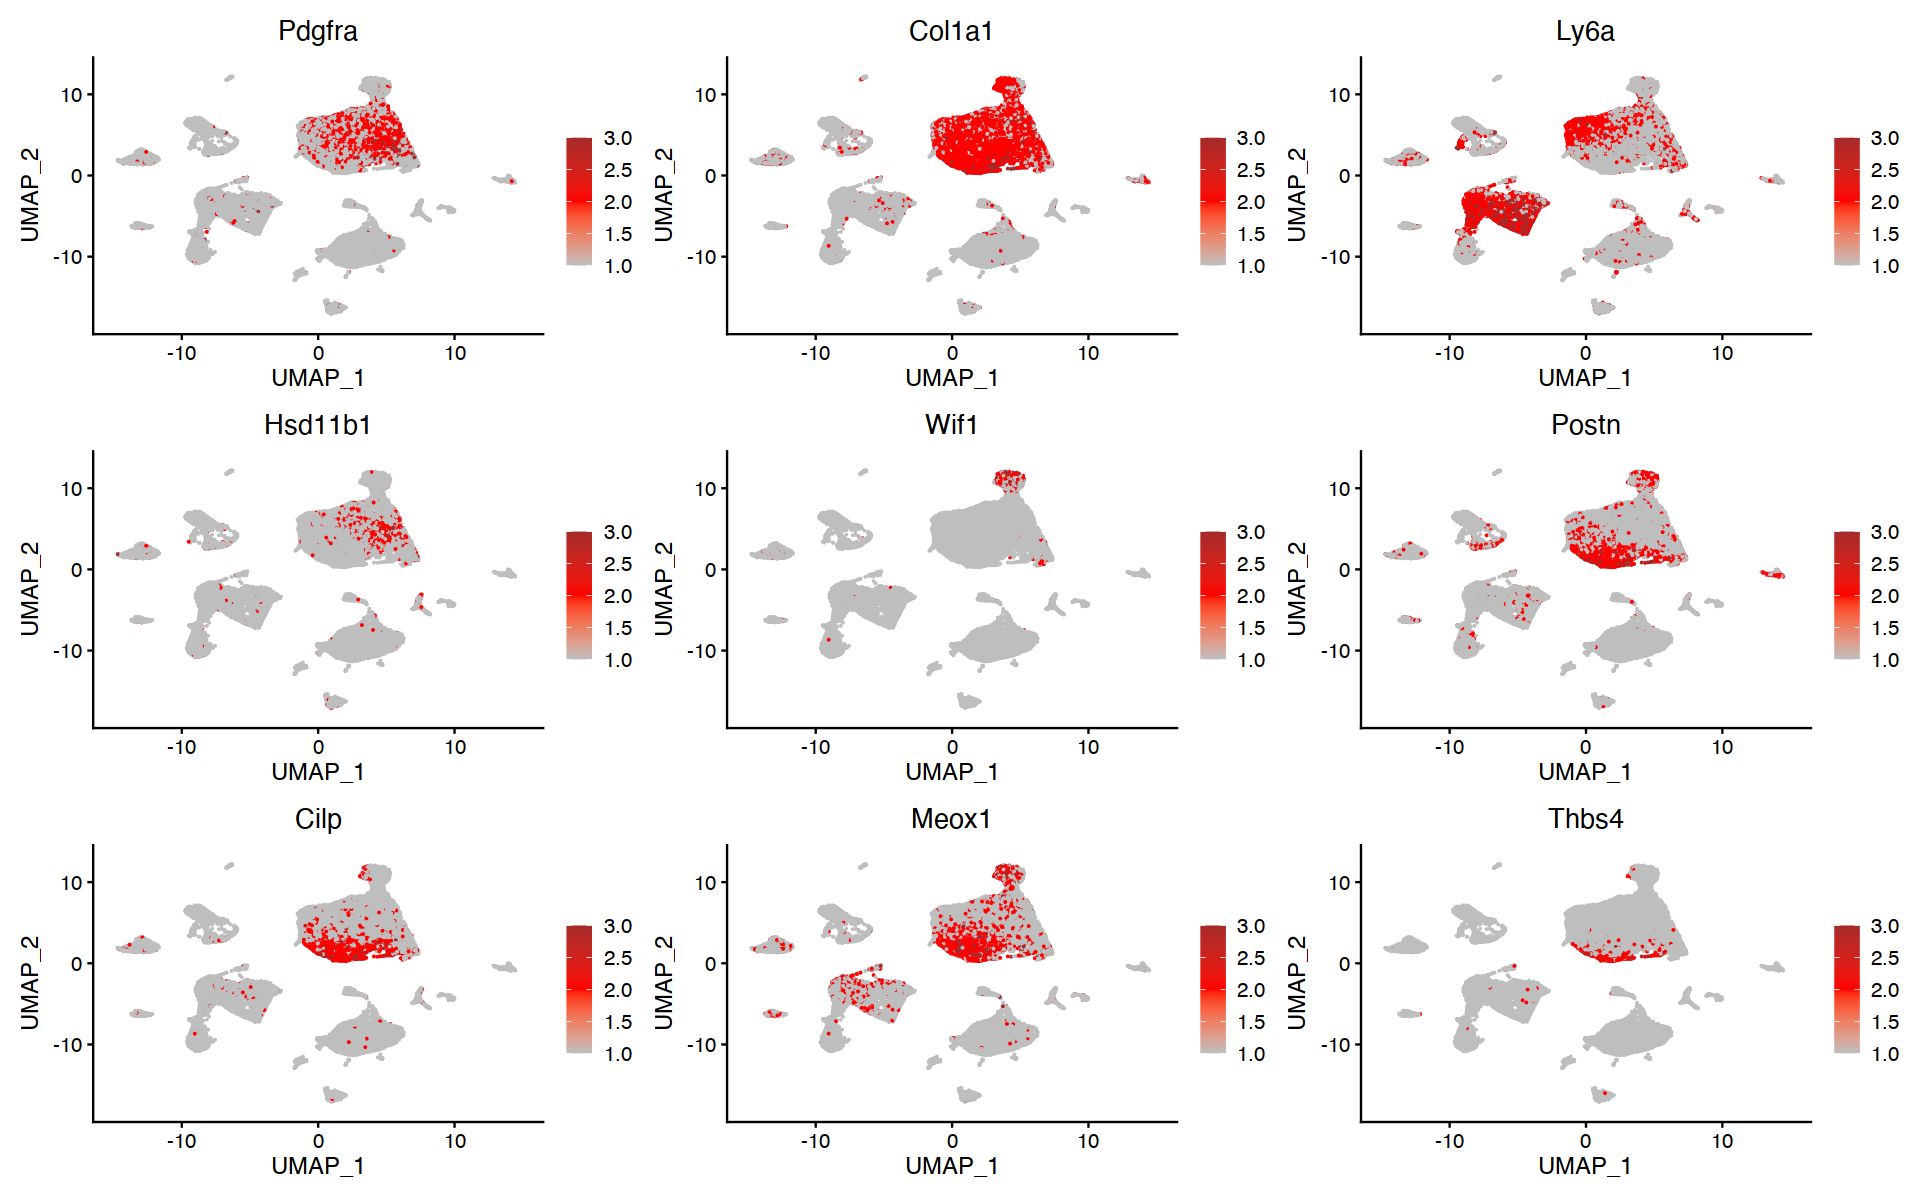

In [15]:
 options(repr.plot.width=16, repr.plot.height=10)
FeaturePlot(genes.seurat, c("Pdgfra", "Col1a1", "Ly6a", "Hsd11b1", "Wif1", "Postn", "Cilp", "Meox1", "Thbs4"),
cols = c("grey", "red", "brown"))

# Select fibroblasts
Will subset high confidence fibroblasts - clusters 0, 2, 3 and 7. Cluster 4 is low for RNA counts and high for mito counts and may represent damaged cells. 

[1] 18267 14056

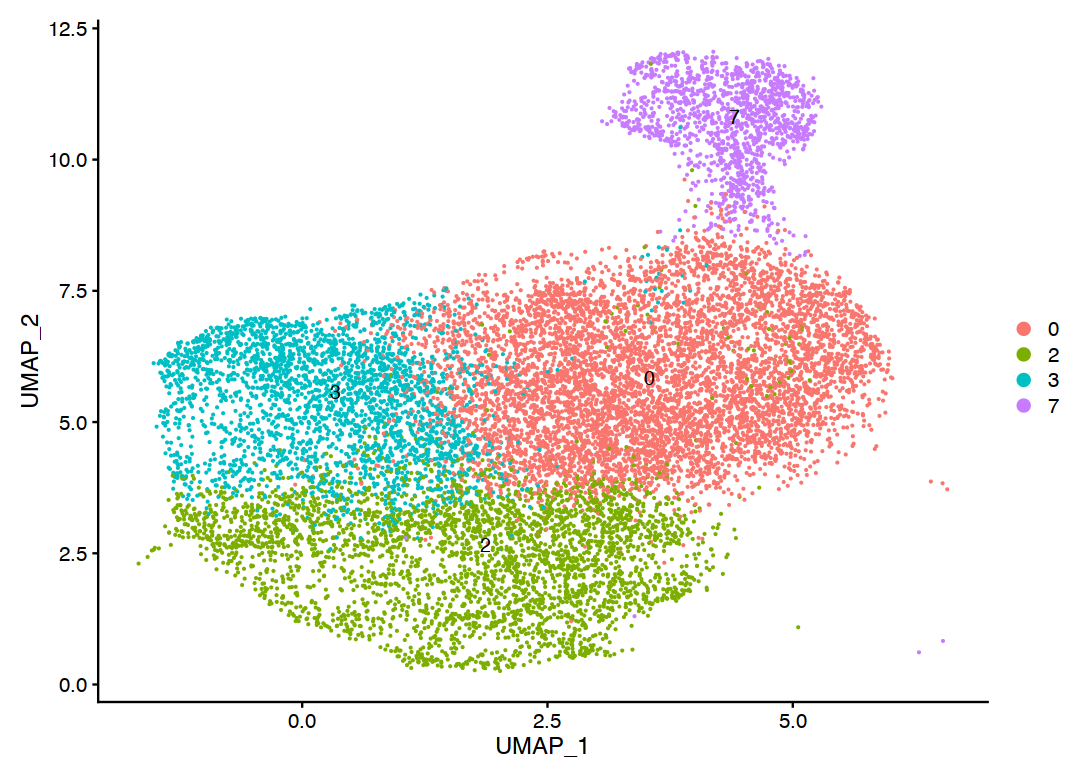

In [19]:
fibro.clusters <- c("0", "2", "3", "7")

fibroblasts.seurat <- subset(genes.seurat, idents = fibro.clusters)
dim(fibroblasts.seurat)

fibroblasts.seurat <- subset(fibroblasts.seurat, UMAP_1 > -3 & UMAP_1 < 7)
fibroblasts.seurat <- subset(fibroblasts.seurat, UMAP_2 > 0)

options(repr.plot.width=9, repr.plot.height=6.5)
DimPlot(fibroblasts.seurat, label = TRUE)


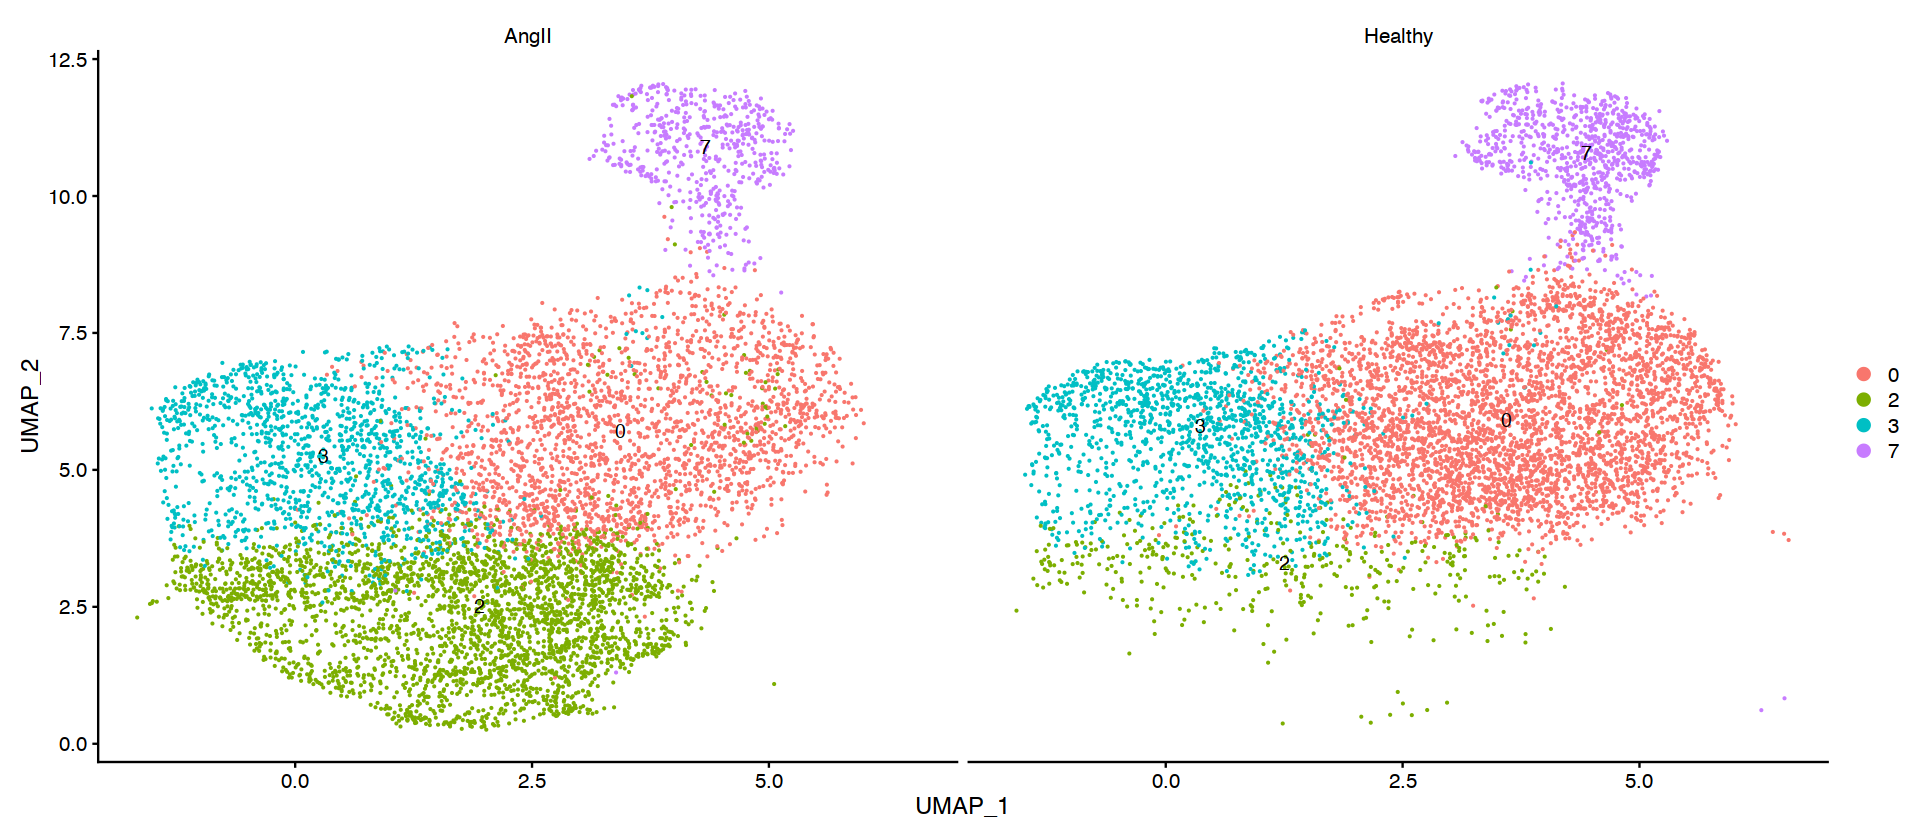

In [20]:
options(repr.plot.width=16, repr.plot.height=7)
DimPlot(fibroblasts.seurat, label = TRUE, split.by = "Condition", ncol = 2)

# Session information

In [21]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Matrix_1.3-4       dplyr_1.0.7        plyr_1.8.6         SeuratObject_4.0.2
[5] Seurat_4.0.3       ggplot2_3.3.5     

loaded via a namespace (and not attached):
  [1] nlme_3.1-152          spatstat.sparse_2.0-0 matrixStats_0.60.0   
  [4] RcppAnnoy_0.0.19      RColorBrewer_1.1-2    httr_1.4.2           
  [7] repr_1.1.3            sctransform_0.3.2     tools_4.1.0          
 [10] utf8_1.2.2            R6_2.5.0              irlba_2.3.3          
 [13] rpart_4.1-15          KernSmooth_2.23-20 